<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Premier prototype</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Première implémentation d'un CNN sur les images
<hr style="border-width:2px;border-color:##75DFC1">

>CNN sur Keras

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

#os.chdir('COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv')

In [2]:
df.head()

,path,Class,height,width,channel,B&W,luminosite
0,COVID/COVID (934).png,covid,331.0,331.0,3.0,True,106.488376
1,COVID/COVID (296).png,covid,256.0,256.0,3.0,True,119.666504
2,COVID/COVID (74).png,covid,256.0,256.0,3.0,True,153.078995
3,COVID/COVID (261).png,covid,256.0,256.0,3.0,True,186.787781
4,COVID/COVID (978).png,covid,331.0,331.0,3.0,True,159.006818


# Normalisation des images

# Normalisation d'histogramme

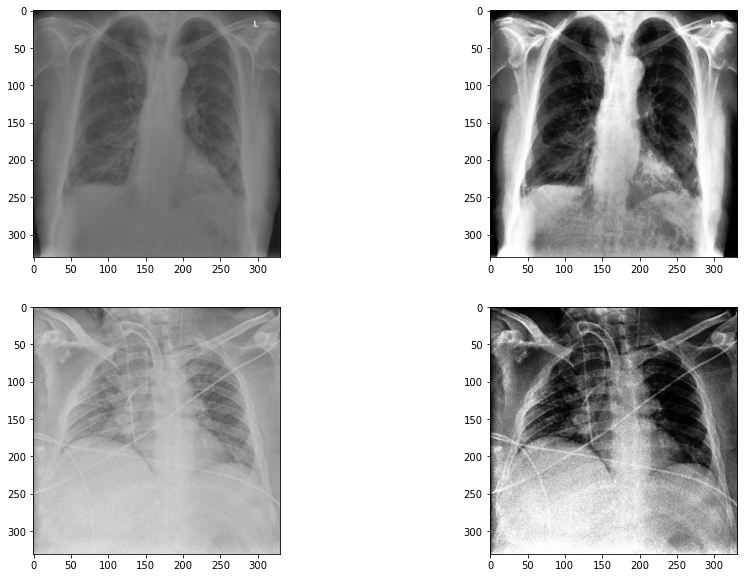

In [40]:
import cv2
import numpy as np


image = cv2.imread(df['path'][0])
image_normal = cv2.imread("C:/Users/adeik/dst/dec20_bc_ds/COVID/COVID (997).png")

# convert image from RGB to HSV
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Histogram equalisation on the V-channel
img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])

# convert image back from HSV to RGB
img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)


img_hsv_normal = cv2.cvtColor(image_normal, cv2.COLOR_RGB2HSV)

# Histogram equalisation on the V-channel
img_hsv_normal[:, :, 2] = cv2.equalizeHist(img_hsv_normal[:, :, 2])

# convert image back from HSV to RGB
img_hsv_normal = cv2.cvtColor(img_hsv_normal, cv2.COLOR_HSV2RGB)

plt.subplot(2, 2, 1)
plt.imshow(image)

plt.subplot(2, 2, 2)
plt.imshow(img_hsv)

plt.subplot(2, 2, 3)
plt.imshow(image_normal)

plt.subplot(2, 2, 4)
plt.imshow(img_hsv_normal)

fig = plt.gcf()

fig.set_size_inches(15, 10)

# Normalisation Quantile-Quantile

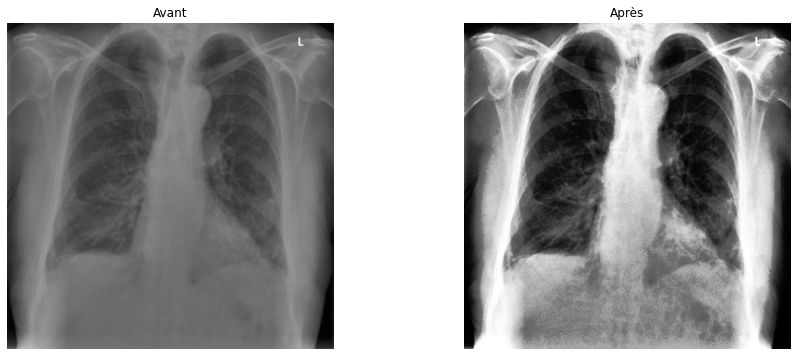

In [35]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer()

# Lecture de l'image
original = plt.imread(df['path'][0])

# Normalisation
normalise = qt.fit_transform(original.flatten().reshape(-1, 1))
normalise = normalise.reshape(original.shape)

# Affichage

plt.subplot(1, 2, 1)
plt.imshow(original, cmap = 'gray')
plt.title("Avant")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normalise, cmap = 'gray')
plt.title("Après")
plt.axis("off")


# Pour agrandir l'affichage
fig = plt.gcf()
fig.set_size_inches(15, 6)

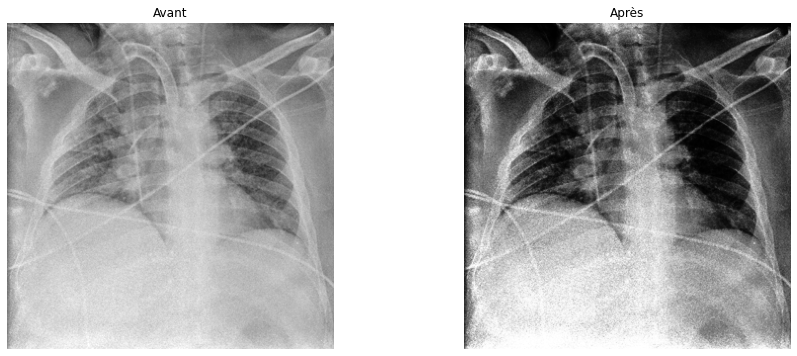

In [36]:

    
qt = QuantileTransformer()

# Lecture de l'image
original = plt.imread("C:/Users/adeik/dst/dec20_bc_ds/COVID/COVID (997).png")

# Normalisation
normalise = qt.fit_transform(original.flatten().reshape(-1, 1))
normalise = normalise.reshape(original.shape)

# Affichage

plt.subplot(1, 2, 1)
plt.imshow(original, cmap = 'gray')
plt.title("Avant")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normalise, cmap = 'gray')
plt.title("Après")
plt.axis("off")


# Pour agrandir l'affichage
fig = plt.gcf()
fig.set_size_inches(15, 6)

# Entrainement d'un CNN

In [7]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.02,
                                   zoom_range = 0.02,
                                   rotation_range=15,                   # le plus important
                                   width_shift_range=0.02,
                                   height_shift_range=0.02,
                                   brightness_range = [0.9, 1.1],       # avant ou après le rescale ?
                                   horizontal_flip=False,               # pas de flip pour des images médicales
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
data = df[['path', 'Class']]
data['Class'] = data['Class'].replace({'covid' : 1, 'normal' : 0, 'pneumo' : 2})

data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

C:\Users\adeik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
data_train

,path,Class
2396,NORMAL/NORMAL (1192).png,0
1120,COVID/COVID (865).png,1
1840,NORMAL/NORMAL (316).png,0
1134,COVID/COVID (219).png,1
1268,NORMAL/NORMAL (350).png,0
...,...,...
1122,COVID/COVID (1147).png,1
1346,NORMAL/NORMAL (193).png,0
3454,Viral Pneumonia/Viral Pneumonia (1096).png,2
3437,Viral Pneumonia/Viral Pneumonia (468).png,2


In [11]:
batch_size = 32

data_train["Class"] = data_train["Class"].astype(str)
data_test["Class"] = data_test["Class"].astype(str)

training_set = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                 directory="",
                                                 x_col = "path",
                                                 y_col = "Class",
                                                 target_size = (160, 160),   # plus petite dimension du dataset
                                                 batch_size = batch_size, 
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=data_test,
                                            directory="",
                                            x_col = "path",
                                            y_col = "Class",
                                            target_size = (160, 160),
                                            batch_size = batch_size,
                                            color_mode='grayscale',
                                            class_mode = 'categorical')

C:\Users\adeik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\adeik\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found 3066 validated image filenames belonging to 3 classes.
Found 770 validated image filenames belonging to 3 classes.


C:\Users\adeik\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 42 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\adeik\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 8 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
classifier = Sequential()

conv2d_5 = Conv2D(filters = 32, 
                  kernel_size = (3, 3), 
                  padding = 'valid', 
                  input_shape = (160, 160, 1))

batch_norm_1 = BatchNormalization()
activation_1 = Activation('relu')

max_pooling2d_5 = MaxPooling2D(pool_size = (2, 2))

conv2d_6 = Conv2D(filters = 32,                    
                  kernel_size = (3, 3),          
                  padding = 'valid')

batch_norm_2 = BatchNormalization()
activation_2 = Activation('relu')


max_pooling2d_6 = MaxPooling2D(pool_size = (2, 2))

flatten_3 = Flatten()

dense_5 = Dense(units = 128)
batch_norm_3 = BatchNormalization()
activation_3 = Activation('relu')

dense_6 = Dense(units = 3,
                activation = 'softmax')

classifier.add(conv2d_5)
classifier.add(batch_norm_1)
classifier.add(activation_1)
classifier.add(max_pooling2d_5)
classifier.add(conv2d_6)
classifier.add(batch_norm_2)
classifier.add(activation_2)
classifier.add(max_pooling2d_6)
classifier.add(Dropout(0.25))     # pour éviter le sur-apprentissage
classifier.add(flatten_3)
classifier.add(dense_5)
classifier.add(batch_norm_3)
classifier.add(activation_3)
classifier.add(Dropout(0.2))           # pour éviter le sur-apprentissage
classifier.add(dense_6)

# Compilation
classifier.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 158, 158, 32)      320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 158, 158, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 158, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 77, 77, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 77, 77, 32)       

In [13]:
# Entraînement
history = classifier.fit(training_set, 
                         epochs = 5,
                         workers = -1,
                         steps_per_epoch = len(data_train)//batch_size,
                         validation_data = test_set,
                         validation_steps = len(data_test)//batch_size)

Epoch 1/5
97/97 [==============================] - 193s 2s/step - loss: 0.2875 - accuracy: 0.8932 - val_loss: 2.6899 - val_accuracy: 0.3893
Epoch 2/5
97/97 [==============================] - 176s 2s/step - loss: 0.2089 - accuracy: 0.9283 - val_loss: 1.8341 - val_accuracy: 0.3469
Epoch 3/5
97/97 [==============================] - 99s 1s/step - loss: 0.1982 - accuracy: 0.9316 - val_loss: 1.7653 - val_accuracy: 0.5027
Epoch 4/5
97/97 [==============================] - 97s 1s/step - loss: 0.1463 - accuracy: 0.9467 - val_loss: 1.4238 - val_accuracy: 0.4309
Epoch 5/5
97/97 [==============================] - 101s 1s/step - loss: 0.1439 - accuracy: 0.9496 - val_loss: 0.5255 - val_accuracy: 0.7046


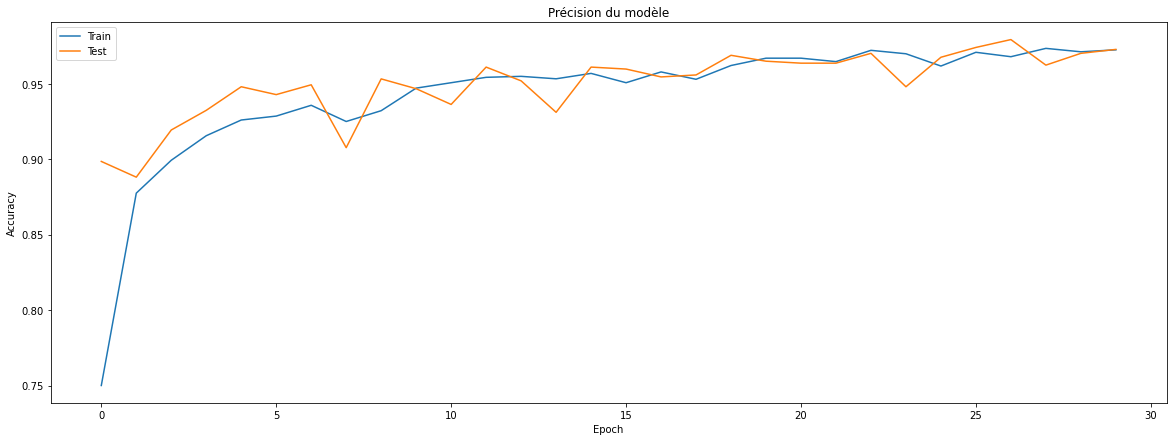

In [11]:
plt.figure(figsize = (20,7))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Précision du modèle")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [12]:
# enregistrement du modèle 

classifier.save('premier_prototype.h5')